In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from pandas_datareader import data as pdr
import yfinance as yf

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [21]:
tickers =["SPY"]
df = yf.download(tickers, period='5y', interval='1d')

df = df.dropna()
df = df[['Open', 'High', 'Low', 'Close']]
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2018-04-09,261.369995,264.839996,259.940002,261.000000
2018-04-10,264.269989,266.040009,262.980011,265.149994
2018-04-11,263.470001,265.640015,263.390015,263.760010
2018-04-12,265.260010,267.000000,265.059998,265.929993
2018-04-13,267.410004,267.540009,264.010010,265.149994


In [22]:
df['Open-Close'] = df.Open - df.Close
df['High-Low'] = df.High - df.Low
df = df.dropna()
X = df[['Open-Close', 'High-Low']]
X.head()

,Open-Close,High-Low
Date,,
2018-04-09,0.369995,4.899994
2018-04-10,-0.880005,3.059998
2018-04-11,-0.290009,2.250000
2018-04-12,-0.669983,1.940002
2018-04-13,2.260010,3.529999


In [23]:
Y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)

In [24]:
split_percent = 0.8
split = int(split_percent * len(df))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)
print(X_train_s.shape)

(1007, 2)


In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.98)
pca.fit(X_train)
X_train_s = pca.transform(X_train)
X_test_s = pca.transform(X_test)
print(X_train_s.shape)

(1007, 2)


In [27]:
knn = KNeighborsClassifier(n_neighbors = 20)

knn.fit(X_train, Y_train)

accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

print('Train data Accuracy: %.2f' %(accuracy_train*100))
print('Train test Accuracy: %.2f' %(accuracy_test*100))

Train data Accuracy: 61.47
Train test Accuracy: 50.40


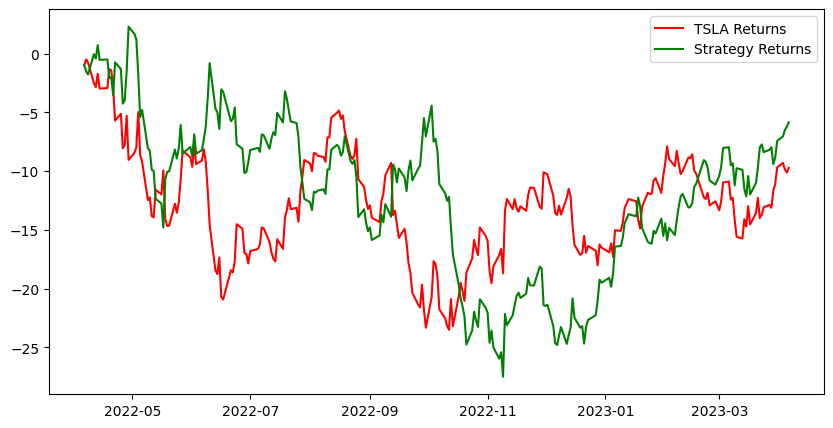

In [28]:
df['Predict_Signal'] = knn.predict(X)

df['SPY_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_TSLA_returns = df[split:]['SPY_returns'].cumsum()*100

df['Startegy_returns'] = df['SPY_returns']* df['Predict_Signal'].shift(1)
Cumulative_Strategy_returns = df[split:]['Startegy_returns'].cumsum()*100

plt.figure(figsize=(10,5))
plt.plot(Cumulative_TSLA_returns, color='r', label = 'TSLA Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

In [29]:
Std = Cumulative_Strategy_returns.std()
Sharpe = (Cumulative_Strategy_returns - Cumulative_TSLA_returns) / Std
Sharpe = Sharpe.mean()
print('Sharpe ratio: %2f' %Sharpe)

Sharpe ratio: 0.133341


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

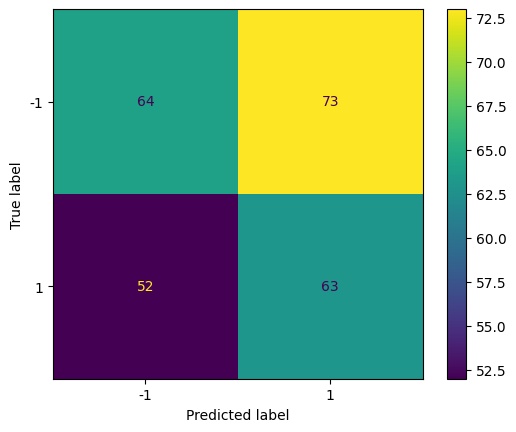

In [31]:
predictions = knn.predict(X_test)
cm = confusion_matrix(Y_test, predictions, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn.classes_)
disp.plot()

plt.show()

In [32]:
from sklearn.metrics import classification_report

In [34]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = Y_test, y_pred = predictions, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.551724,0.467153,0.505929,137.000000
Up Day,0.463235,0.547826,0.501992,115.000000
accuracy,0.503968,0.503968,0.503968,0.503968
macro avg,0.507480,0.507490,0.503960,252.000000
weighted avg,0.511342,0.503968,0.504132,252.000000
